# 🛡️ Detección de Spam
Alumnos:
- Ismael Sihammou
- Victor Jiménez

Este cuaderno tiene como objetivo **construir un modelo de detección de spam** utilizando el **SpamAssassin Public Corpus**.  

El enfoque del proyecto combina:

- **Feature engineering de cabeceras**: extracción de información clave de los headers de los emails (SPF, DKIM, remitente, número de saltos, asunto, etc.).  
- **Embeddings del cuerpo del mensaje**: representación semántica de los textos para capturar significado, contexto y patrones típicos de spam.  

El resultado final será un **modelo híbrido** capaz de identificar correos legítimos (*ham*) y correos no deseados (*spam*), combinando información estructurada (headers) y no estructurada (contenido del email).



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

## Dataset usada
https://www.kaggle.com/datasets/beatoa/spamassassin-public-corpus/data

El **SpamAssassin Public Corpus** es un dataset compuesto por archivos individuales, donde cada archivo es un email completo (cabeceras + cuerpo).
No es un CSV, sino un conjunto de carpetas con muchos mensajes reales.

## El corpus incluye varias carpetas:

* `easy_ham/`: correos legítimos fáciles
* `hard_ham/`: correos legítimos difíciles (parecen spam)
* `spam2/`: correos spam

## Contenido de cada archivo

Cada archivo contiene:

* Cabeceras SMTP (From, To, Subject, Date, Received…)

* Cuerpo del email (texto o HTML)

Esto permite extraer features de headers y aplicar embeddings en el body.

## Carga del dataset

Existe un modulo en python llamado `kagglehub` que nos permite instalar automaticamente el dataset en una ruta cached de nuestro cuaderno

In [ ]:
import kagglehub

# Instalar ultima version del dataset
path = kagglehub.dataset_download("beatoa/spamassassin-public-corpus")

print("Ruta a los archivos del dataset:", path)

Ruta a los archivos del dataset: /root/.cache/kagglehub/datasets/beatoa/spamassassin-public-corpus/versions/2


In [ ]:
# obteniendo ruta a la carpeta de cada tipo de email, lo he modificado para poder usar un entorno de ejecución local
easy_ham_path = path+'/easy_ham/easy_ham/'
hard_ham_path = path +'/hard_ham/hard_ham/'
spam_path = path +'/spam_2/spam_2/'

In [ ]:
import os
# funcion para carga de archivos (emails)
def carga_emails(directorio):
  emails = []
  archivos = os.listdir(directorio)

  for archivo in archivos:
    ruta = directorio + archivo
    with open(ruta, 'r', encoding="ISO-8859-1") as f:
      email = f.read()
      # Filtrar correos
      if re.search(r"^(From|To|Subject|Date|Received)", email, re.IGNORECASE | re.MULTILINE) is None:
        continue
      emails.append(email)

  return emails

In [ ]:
ham = carga_emails(easy_ham_path) + carga_emails(hard_ham_path)
spam = carga_emails(spam_path)

In [ ]:
print('correos legitimos:', len(ham))
print('correos spam:', len(spam))

correos legitimos: 2801
correos spam: 1396


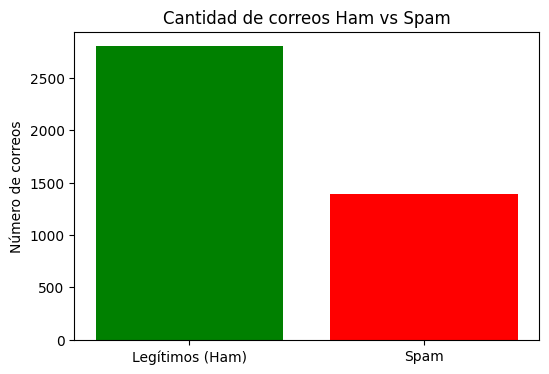

In [ ]:
etiquetas = ['Legítimos (Ham)', 'Spam']
valores = [len(ham), len(spam)]

plt.figure(figsize=(6,4))
plt.bar(etiquetas, valores, color=['green', 'red'])
plt.title('Cantidad de correos Ham vs Spam')
plt.ylabel('Número de correos')
plt.show()

In [ ]:
ham[300]

"From rssfeeds@jmason.org  Wed Oct  2 11:44:03 2002\nReturn-Path: <rssfeeds@example.com>\nDelivered-To: yyyy@localhost.example.com\nReceived: from localhost (jalapeno [127.0.0.1])\n\tby jmason.org (Postfix) with ESMTP id E323116F16\n\tfor <jm@localhost>; Wed,  2 Oct 2002 11:44:02 +0100 (IST)\nReceived: from jalapeno [127.0.0.1]\n\tby localhost with IMAP (fetchmail-5.9.0)\n\tfor jm@localhost (single-drop); Wed, 02 Oct 2002 11:44:02 +0100 (IST)\nReceived: from dogma.slashnull.org (localhost [127.0.0.1]) by\n    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g92830K31815 for\n    <jm@jmason.org>; Wed, 2 Oct 2002 09:03:00 +0100\nMessage-Id: <200210020803.g92830K31815@dogma.slashnull.org>\nTo: yyyy@example.com\nFrom: zawodny <rssfeeds@example.com>\nSubject: Toward Mac OS XX\nDate: Wed, 02 Oct 2002 08:03:00 -0000\nContent-Type: text/plain; encoding=utf-8\nX-Spam-Status: No, hits=-699.3 required=5.0\n\ttests=AWL\n\tversion=2.50-cvs\nX-Spam-Level: \n\nURL: http://jeremy.zawodny.com/blog/arc

Procedemos a dividir cada correo en cabecera para el `Feature Engineering` y cuerpo para el `Embeddings`

In [ ]:
def dividir_correo(correo):
  correo_dividido = correo.split("\n\n", 1) # 1 para dividir por la primera occurencia
  cabecera, cuerpo = correo_dividido[0], correo_dividido[1]
  return {
      "cabecera" : cabecera,
      "cuerpo" : cuerpo,
  }

In [ ]:
# Aplicar sobre correos legitimos
ham_split = list(map(dividir_correo, ham))

In [ ]:
# Aplicar sobre correos spam
spam_split = list(map(dividir_correo, spam))

In [ ]:
for correo in ham_split:
    correo["etiqueta"] = 0  # ham

for correo in spam_split:
    correo["etiqueta"] = 1  # spam

correos = ham_split + spam_split

In [ ]:
# Creacion del Dataframe
correos_all = pd.DataFrame(correos)

In [ ]:
correos_all

,cabecera,cuerpo,etiqueta
0,From rpm-list-admin@freshrpms.net Wed Oct 9 ...,"On Tue, 08 Oct 2002 23:15:07 -0700\nBen Liblit...",0
1,From fork-admin@xent.com Fri Sep 13 20:45:07 ...,The USAF had a program in the 1959-1960 in whi...,0
2,From fork-admin@xent.com Sat Oct 5 12:39:26 ...,"Geege Schuman wrote:\n\n>""British scientists w...",0
3,From rpm-list-admin@freshrpms.net Fri Oct 4 ...,"Jesse Keating wrote:\n\n>On Fri, 04 Oct 2002 0...",0
4,From sitescooper-talk-admin@lists.sourceforge....,"Good Day!\n\nOn Thu, Aug 29, 2002 at 05:10:47P...",0
...,...,...,...
4192,From h_ennis@hotmail.com Mon Jun 24 17:04:15 ...,"<html>\n\n<head>\n<meta http-equiv=3D""Content-...",1
4193,From cgarnett@ORGC.TU-GRAZ.AC.AT Tue Jul 30 1...,<HTML><HEAD><TITLE>New Web Technology</TITLE>\...,1
4194,From JBar204612@aol.com Mon Jun 24 17:06:49 2...,"<html>\n\n<body>\n\n<font size=""2"" PTSIZE=""10""...",1
4195,From sflvx@mail.ru Fri Jun 29 01:52:28 2001\n...,\nGreetings & Blessings To You!\n\nOffering fo...,1


Identificamos las cabeceras que **más se repiten** en todos los correos. Esto nos ayuda a decidir cuáles vale la pena usar como *features*, ya que son las que más información pueden aportar para el modelo 👌

In [ ]:
def extraer_cabeceras(texto):
    found = re.findall(r"^([A-Za-z0-9\-]+):", texto, flags=re.MULTILINE)
    return np.unique(found)

In [ ]:
correos_all["cabeceras_encontradas"] = correos_all["cabecera"].apply(extraer_cabeceras)

In [ ]:
correos_all

,cabecera,cuerpo,etiqueta,cabeceras_encontradas
0,From rpm-list-admin@freshrpms.net Wed Oct 9 ...,"On Tue, 08 Oct 2002 23:15:07 -0700\nBen Liblit...",0,"[Content-Transfer-Encoding, Content-Type, Date..."
1,From fork-admin@xent.com Fri Sep 13 20:45:07 ...,The USAF had a program in the 1959-1960 in whi...,0,"[Content-Transfer-Encoding, Content-Type, Date..."
2,From fork-admin@xent.com Sat Oct 5 12:39:26 ...,"Geege Schuman wrote:\n\n>""British scientists w...",0,"[Cc, Content-Transfer-Encoding, Content-Type, ..."
3,From rpm-list-admin@freshrpms.net Fri Oct 4 ...,"Jesse Keating wrote:\n\n>On Fri, 04 Oct 2002 0...",0,"[Content-Transfer-Encoding, Content-Type, Date..."
4,From sitescooper-talk-admin@lists.sourceforge....,"Good Day!\n\nOn Thu, Aug 29, 2002 at 05:10:47P...",0,"[Content-Disposition, Content-Type, Date, Deli..."
...,...,...,...,...
4192,From h_ennis@hotmail.com Mon Jun 24 17:04:15 ...,"<html>\n\n<head>\n<meta http-equiv=3D""Content-...",1,"[Cc, Content-Transfer-Encoding, Content-Type, ..."
4193,From cgarnett@ORGC.TU-GRAZ.AC.AT Tue Jul 30 1...,<HTML><HEAD><TITLE>New Web Technology</TITLE>\...,1,"[Content-Transfer-Encoding, Content-Type, Date..."
4194,From JBar204612@aol.com Mon Jun 24 17:06:49 2...,"<html>\n\n<body>\n\n<font size=""2"" PTSIZE=""10""...",1,"[Content-Transfer-Encoding, Content-Type, Date..."
4195,From sflvx@mail.ru Fri Jun 29 01:52:28 2001\n...,\nGreetings & Blessings To You!\n\nOffering fo...,1,"[Date, Delivered-To, Errors-To, From, Message-..."


In [ ]:
cabeceras_freq = correos_all["cabeceras_encontradas"].explode().value_counts()

Podemos ver las cabeceras que más se repiten son:

In [ ]:
cabeceras_freq.head(20)

,count
cabeceras_encontradas,
Date,4197
From,4197
Subject,4196
Received,4062
To,4028
Return-Path,3982
Message-Id,3761
Content-Type,3533
Delivered-To,3160


Como tenemos 4197 correos, las cabeceras que aparecen en **todos** los correos, sean spam o ham, son:  
* `Date`  
* `From`  

Otras cabeceras que aparecen en la **gran mayoría** (≈95%) de los correos son:  
* `Subject`  
* `Received`  
* `To`  
* `Return-Path`

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 [Text(0, 0, 'Date'),
  Text(1, 0, 'From'),
  Text(2, 0, 'Subject'),
  Text(3, 0, 'Received'),
  Text(4, 0, 'To'),
  Text(5, 0, 'Return-Path'),
  Text(6, 0, 'Message-Id'),
  Text(7, 0, 'Content-Type'),
  Text(8, 0, 'Delivered-To'),
  Text(9, 0, 'MIME-Version'),
  Text(10, 0, 'X-Spam-Status'),
  Text(11, 0, 'X-Spam-Level'),
  Text(12, 0, 'Precedence'),
  Text(13, 0, 'Sender'),
  Text(14, 0, 'Content-Transfer-Encoding'),
  Text(15, 0, 'List-Unsubscribe'),
  Text(16, 0, 'List-Id'),
  Text(17, 0, 'Errors-To'),
  Text(18, 0, 'X-Mailman-Version'),
  Text(19, 0, 'X-Beenthere'),
  Text(20, 0, 'List-Subscribe')])

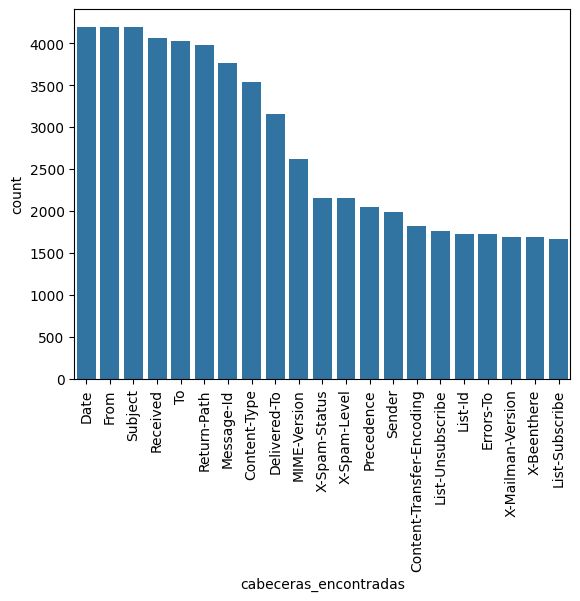

In [ ]:
sns.barplot(data=pd.DataFrame(cabeceras_freq[:21]), x='cabeceras_encontradas', y='count')
plt.xticks(rotation='vertical')

### Explicaicon de las cabeceras cogiendo como referencia un correo legitimo dentro del datset

* `From: Robert Elz <kre@munnari.OZ.AU>`: la cabecera visible con el remitente “humano” (parte del mensaje, no del envelope).

* `To:` / `Cc:` Destinatario(s) visibles del mensaje. Pueden diferir de los destinatarios del envelope (RCPT TO). En tu correo hay `To:` y `Cc:` indicando lista y persona.

* `Subject: Re: New Sequences Window` Asunto del mensaje.

* `Date: Thu, 22 Aug 2002 18:26:25 +0700` Fecha y hora que el remitente puso en el header (puede tener desfase por zonas horarias). No confundir con las marcas de tiempo de los `Received:`.

* `Message-Id: <13258.1030015585@munnari.OZ.AU>`: Identificador único del mensaje. Lo genera el MUA o MTA del remitente para poder referenciar la conversación (threads, replies). Suele contener el hostname del origen.

* `Return-Path: <exmh-workers-admin@example.com>`: Refleja el **envelope sender** (el remitente técnico usado por SMTP). Si el correo rebota, el bounce va a esta dirección. **Este es el `MAIL FROM`** que se usó en SMTP.

* `Delivered-To: zzzz@localhost.netnoteinc.com`: Indica la dirección final a la que el servidor entregó el mail. Es añadido por el servidor de entrega final.

* `Received: ...` (varias) rastro hop-a-hop. Siempre revisa de **abajo arriba** para seguir el origen real.

* `MIME-Version: 1.0` y `Content-Type: text/plain; charset=us-ascii`: Indican que el cuerpo está formateado usando MIME, y que el contenido es texto plano en ASCII. Si hubiera adjuntos o HTML, `Content-Type` refleja multipart/alternative, text/html, etc.

* `X-Loop: exmh-workers@example.com`: Un header **X-**es no estandar, añadido por software para control interno. `X-Loop` lo usan listas de correo para evitar reenvíos infinitos (loop detection).

* `Precedence: bulk`: Suele usarse en listas/automáticos para indicar tratamiento especial (por ejemplo, silenciar respuestas automáticas como out-of-office).

* `Sender:` puede indicar la dirección responsable cuando `From:` contiene un grupo.
* `Errors-To:` define a dónde deberían enviarse informes de error (antiguo, muchos MTAs ya usan Return-Path).

* `X-Beenthere: exmh-workers@example.com` y `X-Mailman-Version: 2.0.1`: Añadidos por Mailman (software de listas). `X-Beenthere` indica que el mensaje ya pasó por esa lista; `X-Mailman-Version` indica la versión del software.

* `List-*` headers (**List-Help, List-Post, List-Subscribe, List-Unsubscribe, List-Archive, List-Id**): metadatos que las listas de correo añaden para que los clientes/mecanismos automaticos sepan cómo interactuar con la lista (suscribirse, ver archivo, instrucciones, etc.). Ejemplos en tu archivo:

## Feature Engineering

Una vez identificadas las cabeceras más frecuentes en los correos electrónicos y comprendida su función, podemos diseñar y extraer nuevas características que permitan al modelo aprender patrones relevantes.

Es recomendable priorizar **características numéricas o categóricas simples**, ya que facilitan la interpretación del modelo y mejoran el rendimiento de los algoritmos de clasificación.

A continuación se describen las características extraídas y la razón de su inclusión:

| **Característica** | **Motivación / Justificación** |
| --- | --- |
| **num_received_headers** | Los correos spam suelen tener demasiadas o muy pocas cabeceras *Received*, lo que es indicativo de manipulación. |
| **received_first_ip_is_private** | El primer salto en la cadena de *Received* no debería ser una IP privada; puede indicar envío fraudulento. |
| **from_returnpath_match** | Si *From* y *Return-Path* no coinciden, es un síntoma frecuente de phishing. |
| **reply_to_differs_from_from** | Un *Reply-To* diferente del *From* es un indicador fuerte de intento de redirección sospechosa. |
| **message_id_missing** | Los correos legítimos casi siempre incluyen *Message-ID*; su ausencia es señal de spam. |
| **message_id_matches_from** | Comprobación de coherencia entre el dominio del *Message-ID* y el remitente. |
| **message_id_is_random** | Algunos spammers generan *Message-ID* aleatorios; detectar este patrón ayuda a clasificar. |
| **subject_length** | Asuntos demasiado cortos o inusualmente largos pueden correlacionarse con spam. |
| **subject_starts_with_re_fwd** | Muchos correos maliciosos simulan ser respuestas reenviadas para ganar confianza. |
| **num_recipients** | El envío masivo es un patrón típico del spam. |
| **to_contains_undisclosed_recipients** | La presencia de recipientes ocultos es común en envíos automatizados sospechosos. |
| **is_html** | Los correos spam suelen usar HTML enriquecido. |
| **is_multipart** | Correos multipart pueden ocultar contenido malicioso en partes alternativas. |
| **num_list_headers** | Cabeceras como `List-Unsubscribe` o `List-ID` indican envíos de mailing legítimos; su ausencia o exceso puede ser informativa. |


### Algunas diferencias entre correo legitimo y spam
             Ham                                                            Spam
<img src='https://drive.google.com/uc?export=view&id=1XriasHUJWCg1OhqxcfviJCRh8AhvRoiu'>

## Crear Features surgidos para cada correo

In [ ]:
def get_cabecera(correo, nombre_cabecera):
    patron = rf"^{nombre_cabecera}:\s*(.*)$"
    match = re.search(patron, correo, flags=re.IGNORECASE | re.MULTILINE)
    return match.group(1).strip() if match else None

In [ ]:
def num_received_headers(correo):
    return len(re.findall(r'^Received:', correo, flags=re.IGNORECASE | re.MULTILINE))


def received_first_ip_is_private(correo):
    patrones_privados = [
        r'^10\.',
        r'^192\.168\.',
        r'^172\.(1[6-9]|2\d|3[0-1])\.',
    ]

    received_headers = re.findall(r'^Received: (.*)$', correo, flags=re.IGNORECASE | re.MULTILINE)
    if not received_headers:
        return 0

    # ultimo es rimero en la cadena real
    first_hop = received_headers[-1]
    ip_match = re.search(r"\b(\d{1,3}(?:\.\d{1,3}){3})\b", first_hop)

    if not ip_match:
        return 0

    ip = ip_match.group(1)

    return int(any(re.match(p, ip) for p in patrones_privados))


def from_returnpath_match(correo):
    from_c = get_cabecera(correo, "From")
    rpath = get_cabecera(correo, "Return-Path")

    if not from_c or not rpath:
        return 0

    d_from = re.findall(r"@([\w\.-]+)", from_c)
    d_rp   = re.findall(r"@([\w\.-]+)", rpath)

    if not d_from or not d_rp:
        return 0

    # 1 si no coinciden
    return int(d_from[0].lower() != d_rp[0].lower())


def reply_to_differs_from_from(correo):
    from_c = get_cabecera(correo, "From")
    reply_to = get_cabecera(correo, "Reply-To")

    if not from_c or not reply_to:
        return 0

    d_from = re.findall(r"@([\w\.-]+)", from_c)
    d_rt   = re.findall(r"@([\w\.-]+)", reply_to)

    if not d_from or not d_rt:
        return 0

    # 1 si son diferentes
    return int(d_from[0].lower() != d_rt[0].lower())


def message_id_missing(correo):
    return int(get_cabecera(correo, 'Message-ID') is None)


def message_id_matches_from(correo):
    from_c = get_cabecera(correo, "From")
    msgid  = get_cabecera(correo, "Message-ID")

    if not from_c or not msgid:
        return 0

    d_from = re.findall(r"@([\w\.-]+)", from_c)
    d_msg  = re.findall(r"@([\w\.-]+)", msgid)

    if not d_from or not d_msg:
        return 0

    # 1 si no coinciden
    return int(d_from[0].lower() != d_msg[0].lower())


def message_id_is_random(correo):
    msgid = get_cabecera(correo, "Message-ID")
    if not msgid:
        return 0

    local = msgid.split("@")[0]

    return int(bool(
        len(local) > 25
        and re.search(r"[A-Za-z]", local)
        and re.search(r"\d", local))
    )


def subject_length(correo):
    sub = get_cabecera(correo, "Subject")
    return len(sub) if sub else 0


def subject_starts_with_re_fwd(correo):
    sub = get_cabecera(correo, "Subject") or ""
    return int(bool(re.match(r"^(re:|fwd:)", sub, flags=re.IGNORECASE)))


def num_recipients(correo):
    to = get_cabecera(correo, "To") or ""
    cc = get_cabecera(correo, "CC") or ""
    return len(re.findall(r"@[\w\.-]+", to)) + len(re.findall(r"@[\w\.-]+", cc))


def to_contains_undisclosed_recipients(correo):
    to = get_cabecera(correo, "To") or ""
    return int("undisclosed" in to.lower())


def is_html(correo):
    ct = get_cabecera(correo, "Content-Type") or ""
    return int("text/html" in ct.lower())


def is_multipart(correo):
    ct = get_cabecera(correo, "Content-Type") or ""
    return int("multipart/" in ct.lower())


def num_list_headers(correo):
    return len(re.findall(r"^List-[A-Za-z\-]+:", correo, flags=re.IGNORECASE | re.MULTILINE))

In [ ]:
feature_functions = {
    "num_received_headers": num_received_headers,
    "received_first_ip_is_private": received_first_ip_is_private,
    "from_returnpath_match": from_returnpath_match,
    "reply_to_differs_from_from": reply_to_differs_from_from,
    "message_id_missing": message_id_missing,
    "message_id_matches_from": message_id_matches_from,
    "message_id_is_random": message_id_is_random,
    "subject_length": subject_length,
    "subject_starts_with_re_fwd": subject_starts_with_re_fwd,
    "num_recipients": num_recipients,
    "to_contains_undisclosed_recipients": to_contains_undisclosed_recipients,
    "is_html": is_html,
    "is_multipart": is_multipart,
    "num_list_headers": num_list_headers
}

In [ ]:
for name, func in feature_functions.items():
    correos_all[name] = correos_all["cabecera"].apply(func)

In [ ]:
correos_all

,cabecera,cuerpo,etiqueta,cabeceras_encontradas,num_received_headers,received_first_ip_is_private,from_returnpath_match,reply_to_differs_from_from,message_id_missing,message_id_matches_from,message_id_is_random,subject_length,subject_starts_with_re_fwd,num_recipients,to_contains_undisclosed_recipients,is_html,is_multipart,num_list_headers
0,From rpm-list-admin@freshrpms.net Wed Oct 9 ...,"On Tue, 08 Oct 2002 23:15:07 -0700\nBen Liblit...",0,"[Content-Transfer-Encoding, Content-Type, Date...",6,1,1,1,0,0,1,35,1,1,0,0,0,6
1,From fork-admin@xent.com Fri Sep 13 20:45:07 ...,The USAF had a program in the 1959-1960 in whi...,0,"[Content-Transfer-Encoding, Content-Type, Date...",6,0,1,0,0,0,1,16,1,1,0,0,0,6
2,From fork-admin@xent.com Sat Oct 5 12:39:26 ...,"Geege Schuman wrote:\n\n>""British scientists w...",0,"[Cc, Content-Transfer-Encoding, Content-Type, ...",6,1,1,0,0,0,0,44,1,3,0,0,0,6
3,From rpm-list-admin@freshrpms.net Fri Oct 4 ...,"Jesse Keating wrote:\n\n>On Fri, 04 Oct 2002 0...",0,"[Content-Transfer-Encoding, Content-Type, Date...",7,0,1,1,0,0,0,7,1,1,0,0,0,6
4,From sitescooper-talk-admin@lists.sourceforge....,"Good Day!\n\nOn Thu, Aug 29, 2002 at 05:10:47P...",0,"[Content-Disposition, Content-Type, Date, Deli...",9,0,1,0,0,1,0,94,1,1,0,0,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4192,From h_ennis@hotmail.com Mon Jun 24 17:04:15 ...,"<html>\n\n<head>\n<meta http-equiv=3D""Content-...",1,"[Cc, Content-Transfer-Encoding, Content-Type, ...",2,0,0,0,0,1,1,44,0,4,0,1,0,0
4193,From cgarnett@ORGC.TU-GRAZ.AC.AT Tue Jul 30 1...,<HTML><HEAD><TITLE>New Web Technology</TITLE>\...,1,"[Content-Transfer-Encoding, Content-Type, Date...",4,0,0,0,0,1,1,37,0,1,0,1,0,0
4194,From JBar204612@aol.com Mon Jun 24 17:06:49 2...,"<html>\n\n<body>\n\n<font size=""2"" PTSIZE=""10""...",1,"[Content-Transfer-Encoding, Content-Type, Date...",3,0,0,0,0,1,1,41,0,2,0,1,0,0
4195,From sflvx@mail.ru Fri Jun 29 01:52:28 2001\n...,\nGreetings & Blessings To You!\n\nOffering fo...,1,"[Date, Delivered-To, Errors-To, From, Message-...",3,0,0,0,0,1,1,27,0,1,0,0,0,0


In [ ]:
datos_completos = correos_all[["num_received_headers", "received_first_ip_is_private", "from_returnpath_match", "reply_to_differs_from_from", "message_id_missing", "message_id_matches_from", "message_id_is_random", "subject_length", "subject_starts_with_re_fwd", "num_recipients", "to_contains_undisclosed_recipients", "is_html", "is_multipart", "num_list_headers", "cuerpo", "etiqueta"]]

In [ ]:
datos_completos

,num_received_headers,received_first_ip_is_private,from_returnpath_match,reply_to_differs_from_from,message_id_missing,message_id_matches_from,message_id_is_random,subject_length,subject_starts_with_re_fwd,num_recipients,to_contains_undisclosed_recipients,is_html,is_multipart,num_list_headers,cuerpo,etiqueta
0,6,1,1,1,0,0,1,35,1,1,0,0,0,6,"On Tue, 08 Oct 2002 23:15:07 -0700\nBen Liblit...",0
1,6,0,1,0,0,0,1,16,1,1,0,0,0,6,The USAF had a program in the 1959-1960 in whi...,0
2,6,1,1,0,0,0,0,44,1,3,0,0,0,6,"Geege Schuman wrote:\n\n>""British scientists w...",0
3,7,0,1,1,0,0,0,7,1,1,0,0,0,6,"Jesse Keating wrote:\n\n>On Fri, 04 Oct 2002 0...",0
4,9,0,1,0,0,1,0,94,1,1,0,0,0,6,"Good Day!\n\nOn Thu, Aug 29, 2002 at 05:10:47P...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4192,2,0,0,0,0,1,1,44,0,4,0,1,0,0,"<html>\n\n<head>\n<meta http-equiv=3D""Content-...",1
4193,4,0,0,0,0,1,1,37,0,1,0,1,0,0,<HTML><HEAD><TITLE>New Web Technology</TITLE>\...,1
4194,3,0,0,0,0,1,1,41,0,2,0,1,0,0,"<html>\n\n<body>\n\n<font size=""2"" PTSIZE=""10""...",1
4195,3,0,0,0,0,1,1,27,0,1,0,0,0,0,\nGreetings & Blessings To You!\n\nOffering fo...,1


## Embedding del cuerpo

Limpiamos primero el contenido de etiquetas `html` y espacios inecesarios

In [ ]:
def limpiar_texto(texto):
    texto = re.sub(r"<.*?>", "", texto)
    texto = re.sub(r"\s+", " ", texto)
    return texto.strip()

In [ ]:
datos_completos['cuerpo'] = datos_completos['cuerpo'].apply(limpiar_texto)
datos_completos['cuerpo']

/tmp/ipython-input-2156228323.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_completos['cuerpo'] = datos_completos['cuerpo'].apply(limpiar_texto)


,cuerpo
0,"On Tue, 08 Oct 2002 23:15:07 -0700 Ben Liblit ..."
1,The USAF had a program in the 1959-1960 in whi...
2,"Geege Schuman wrote: >""British scientists were..."
3,"Jesse Keating wrote: >On Fri, 04 Oct 2002 01:1..."
4,"Good Day! On Thu, Aug 29, 2002 at 05:10:47PM -..."
...,...
4192,"<meta http-equiv=3D""Content-Type"" content=3D""t..."
4193,New Web Technology <META http-equiv=3DContent-...
4194,"&nbsp; You can't predict the future, but you c..."
4195,Greetings & Blessings To You! Offering for you...


CREACIÓN DE EMBEDDINGS DEL CUERPO DEL CORREO

Se ha generado el embedding de cada correo usando un modelo de Transformers
de HuggingFace: "all-mpnet-base-v2" de la librería Sentence-Transformers.
Cada embedding es un vector de 768 dimensiones que representa el contenido
semántico del correo y se combinará con las features tabulares para el modelo.

In [ ]:
!pip install sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-mpnet-base-v2")

def embed_correo(cuerpo):
    cuerpo = limpiar_texto(cuerpo)
    embedding = model.encode(cuerpo, convert_to_numpy=True)
    return embedding.tolist()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
datos_completos["embedding"] = datos_completos["cuerpo"].apply(embed_correo)

/tmp/ipython-input-110777300.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_completos["embedding"] = datos_completos["cuerpo"].apply(embed_correo)


In [ ]:
datos_completos

,num_received_headers,received_first_ip_is_private,from_returnpath_match,reply_to_differs_from_from,message_id_missing,message_id_matches_from,message_id_is_random,subject_length,subject_starts_with_re_fwd,num_recipients,to_contains_undisclosed_recipients,is_html,is_multipart,num_list_headers,cuerpo,etiqueta,embedding
0,6,1,1,1,0,0,1,35,1,1,0,0,0,6,"On Tue, 08 Oct 2002 23:15:07 -0700 Ben Liblit ...",0,"[-0.030152440071105957, 0.06130608916282654, -..."
1,6,0,1,0,0,0,1,16,1,1,0,0,0,6,The USAF had a program in the 1959-1960 in whi...,0,"[-0.02735309861600399, -0.00296456809155643, 0..."
2,6,1,1,0,0,0,0,44,1,3,0,0,0,6,"Geege Schuman wrote: >""British scientists were...",0,"[0.014133128337562084, 0.04209323227405548, -0..."
3,7,0,1,1,0,0,0,7,1,1,0,0,0,6,"Jesse Keating wrote: >On Fri, 04 Oct 2002 01:1...",0,"[0.03418277949094772, -0.007662239018827677, -..."
4,9,0,1,0,0,1,0,94,1,1,0,0,0,6,"Good Day! On Thu, Aug 29, 2002 at 05:10:47PM -...",0,"[-0.012965389527380466, 0.04539325833320618, 0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4192,2,0,0,0,0,1,1,44,0,4,0,1,0,0,"<meta http-equiv=3D""Content-Type"" content=3D""t...",1,"[0.05597541481256485, 0.030828895047307014, -0..."
4193,4,0,0,0,0,1,1,37,0,1,0,1,0,0,New Web Technology <META http-equiv=3DContent-...,1,"[0.023182235658168793, -0.0043025235645473, -0..."
4194,3,0,0,0,0,1,1,41,0,2,0,1,0,0,"&nbsp; You can't predict the future, but you c...",1,"[-0.0376308336853981, 0.05623616650700569, -0...."
4195,3,0,0,0,0,1,1,27,0,1,0,0,0,0,Greetings & Blessings To You! Offering for you...,1,"[0.0410286970436573, 0.05893690884113312, 0.00..."


El dataframe final seria

In [ ]:
emb_df = pd.DataFrame(datos_completos["embedding"].tolist(),
                      index=datos_completos.index)
emb_df = emb_df.add_prefix("emb_")

datos_finales = pd.concat([datos_completos.drop(columns=["embedding", "cuerpo"]), emb_df], axis=1)
datos_finales

,num_received_headers,received_first_ip_is_private,from_returnpath_match,reply_to_differs_from_from,message_id_missing,message_id_matches_from,message_id_is_random,subject_length,subject_starts_with_re_fwd,num_recipients,...,emb_758,emb_759,emb_760,emb_761,emb_762,emb_763,emb_764,emb_765,emb_766,emb_767
0,6,1,1,1,0,0,1,35,1,1,...,-0.051602,0.027057,-0.011010,0.004119,-0.010567,-0.010491,-0.011686,-0.010132,-0.014765,-0.004603
1,6,0,1,0,0,0,1,16,1,1,...,-0.035157,-0.024868,-0.066329,0.016054,0.033300,0.014530,0.035064,-0.005423,0.008042,0.030469
2,6,1,1,0,0,0,0,44,1,3,...,0.019098,0.022774,-0.010759,0.036733,-0.025333,-0.006758,0.007652,0.071929,0.077399,-0.000459
3,7,0,1,1,0,0,0,7,1,1,...,0.006540,0.041401,-0.046185,0.027797,-0.010887,0.019149,-0.087911,-0.051032,-0.082210,-0.021436
4,9,0,1,0,0,1,0,94,1,1,...,-0.010321,-0.016360,0.048385,0.019618,-0.036218,0.046493,0.045089,0.007832,-0.043122,0.011720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4192,2,0,0,0,0,1,1,44,0,4,...,-0.001119,0.019521,-0.010250,-0.010637,0.032256,0.043621,-0.012029,0.020932,-0.021352,-0.064491
4193,4,0,0,0,0,1,1,37,0,1,...,-0.002091,0.029677,0.034794,-0.010071,0.014046,0.054243,-0.013624,0.006008,0.004204,-0.015361
4194,3,0,0,0,0,1,1,41,0,2,...,-0.001144,-0.035891,-0.030711,0.037237,0.050316,0.001904,0.036218,-0.005320,0.034204,0.017602
4195,3,0,0,0,0,1,1,27,0,1,...,0.027075,0.010810,-0.077163,0.018402,0.002882,0.023765,-0.066566,0.009021,-0.027522,-0.024895


## División el Dataset

In [ ]:
X = datos_finales.drop('etiqueta', axis=1)
y = datos_finales['etiqueta']

print("Dimensiones de X:", X.shape)
print("Dimensiones de y:", y.shape)

Dimensiones de X: (4197, 782)
Dimensiones de y: (4197,)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Dimensiones de X_train:", X_train.shape)
print("Dimensiones de X_test:", X_test.shape)
print("Dimensiones de y_train:", y_train.shape)
print("Dimensiones de y_test:", y_test.shape)

Dimensiones de X_train: (3357, 782)
Dimensiones de X_test: (840, 782)
Dimensiones de y_train: (3357,)
Dimensiones de y_test: (840,)


## Entrenamiento del modelo


In [ ]:
X_test

,num_received_headers,received_first_ip_is_private,from_returnpath_match,reply_to_differs_from_from,message_id_missing,message_id_matches_from,message_id_is_random,subject_length,subject_starts_with_re_fwd,num_recipients,...,emb_758,emb_759,emb_760,emb_761,emb_762,emb_763,emb_764,emb_765,emb_766,emb_767
149,6,0,1,0,0,1,1,17,1,2,...,0.028306,-0.019621,0.025754,0.007708,0.016357,0.001440,0.024596,0.011529,-0.030646,-0.025416
2028,0,0,0,0,0,1,1,64,0,0,...,-0.028706,-0.034716,-0.008302,0.019806,0.002813,0.035719,0.063515,-0.017562,-0.049326,0.023631
3770,4,0,0,0,0,1,0,22,0,1,...,0.013332,0.008071,0.052518,0.001974,-0.020517,-0.018658,-0.000591,-0.033593,-0.071083,-0.039319
800,0,0,0,0,0,0,0,29,0,0,...,0.002305,0.052520,-0.009087,0.010038,-0.013126,0.009469,-0.043441,-0.020053,-0.057167,0.024065
1237,10,0,1,1,0,1,1,60,0,2,...,-0.045612,-0.025698,-0.026332,0.029882,-0.008861,0.082240,0.023836,0.004821,-0.064162,-0.030234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,6,0,1,0,0,1,0,51,1,1,...,-0.037787,0.057141,-0.022186,-0.023367,-0.005601,-0.056697,-0.059354,0.014765,-0.041411,0.010938
881,6,0,1,1,0,0,0,35,1,1,...,-0.026581,-0.014302,-0.054344,0.019237,-0.008509,-0.047473,-0.010155,-0.022545,-0.070498,-0.003637
4035,4,0,0,0,0,1,1,27,0,4,...,-0.048377,-0.002631,-0.034947,0.023100,0.042731,0.020590,-0.009735,-0.006056,-0.074804,-0.040924
239,5,0,1,1,0,0,1,27,1,1,...,-0.020624,0.001093,-0.020587,-0.015890,-0.000066,-0.063102,-0.003836,0.013680,-0.027665,-0.060043


In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [ ]:
import joblib
joblib.dump(model, 'spam_model.pkl')

['spam_model.pkl']

In [ ]:
from lightgbm import LGBMClassifier


lgbm_model = LGBMClassifier(random_state=42)

lgbm_model.fit(X_train, y_train)

y_pred_lgbm = lgbm_model.predict(X_test)
print("LGBMClassifier model trained successfully.")

## Evaluación del Modelo

Evaluación del rendimiento del modelo entrenado utilizando métricas como accuracy, precision, recall, F1-score en el conjunto de prueba (X_test, y_test).
Aquí tienes el significado de cada una resumido en una sola frase:

* **Accuracy:** El porcentaje total de aciertos globales (tanto positivos como negativos).
* **Precision:** La calidad de tus predicciones positivas (cuántos de los que llamaste "positivos" lo eran realmente).
$Precision = \frac{TP}{TP+FP}$
* **Recall:** La capacidad de encontrar todos los casos positivos reales (cuántos del total real detectaste). $Recall = \frac{TP}{TP+FN}$
* **F1:** El equilibrio (media armónica) entre Precision y Recall, ideal cuando hay clases desbalanceadas.
$F1 = \frac{2\times{TP}}{2\times{TP}+FP+FN}$
* **Roc Auc:** La capacidad general del modelo para distinguir y separar bien las clases positivas de las negativas.


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
results_score_df = pd.DataFrame({
    "Modelo": ["RandomForestClassifier", "LGBMClassifier"],
    "Accuracy": [accuracy_score(y_test, y_pred) * 100, accuracy_score(y_test, y_pred_lgbm) * 100],
    "Precision": [precision_score(y_test, y_pred) * 100, precision_score(y_test, y_pred_lgbm) * 100],
    "Recall": [recall_score(y_test, y_pred) * 100, recall_score(y_test, y_pred_lgbm) * 100],
    "F1": [f1_score(y_test, y_pred) * 100, f1_score(y_test, y_pred_lgbm) * 100],
    "Roc_auc": [roc_auc_score(y_test, y_pred) * 100,roc_auc_score(y_test, y_pred_lgbm) * 100]
})


results_score_df

In [ ]:

# Melt the DataFrame to long format for easier plotting
melted_results_df = results_score_df.melt(id_vars='Modelo', var_name='Métrica', value_name='Valor')

plt.figure(figsize=(12, 7))

ax = sns.barplot(x='Métrica', y='Valor', hue='Modelo', data=melted_results_df, palette='viridis')

# 4. AÑADIR ETIQUETAS DE VALOR (Automático)
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3, fontsize=10)

plt.title('Comparación de Modelos')
plt.ylabel('Puntuación (%)')
plt.xlabel('')

# 5. AJUSTE DE ZOOM AUTOMÁTICO
# Detectamos el valor más bajo para ajustar el suelo de la gráfica
min_val = melted_results_df['Valor'].min()
plt.ylim(min_val - 5, 103)

plt.legend(title='Modelo', loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Generación de la matríz de confusión.

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

xtick_labels = ['Ham Predecido', 'Spam Predecido']
ytick_labels = ['Ham Real', 'Spam Real']

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=xtick_labels,
            yticklabels=ytick_labels,
            ax=axes[0])
axes[0].set_title('Matríz de Confusión (RandomForestClassifier)')


sns.heatmap(cm_lgbm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=xtick_labels,
            yticklabels=ytick_labels,
            ax=axes[1])
axes[1].set_title('Matríz de Confusión (LightGBM)')

## Visualización de la Importancia de las Características

Vamos a visualizar las características más importantes que el modelo `RandomForestClassifier` ha identificado para clasificar los correos como spam o no spam. Esto nos ayudará a entender qué aspectos de los correos electrónicos son más influyentes en la toma de decisiones del modelo.

In [ ]:
def obtener_data_ranking(modelo, feature_names):
    importancias = modelo.feature_importances_
    df = pd.DataFrame({'feature': feature_names, 'importance': importancias})
    df = df.sort_values(by='importance', ascending=False)
    df['rank'] = range(1, len(df) + 1)
    return df

df_rf_full = obtener_data_ranking(model, X.columns)
df_lgbm_full = obtener_data_ranking(lgbm_model, X.columns)

top_n = 20
df_rf_plot = df_rf_full.head(top_n).copy()
df_lgbm_plot = df_lgbm_full.head(top_n).copy()

# --- 2. LÓGICA DE COLORES COORDINADOS (HUE) ---
# Unimos las features que aparecerán en la izquierda y en la derecha
features_en_pantalla = set(df_rf_plot['feature']) | set(df_lgbm_plot['feature'])

# Creamos una paleta con suficientes colores únicos
colores = sns.color_palette("tab20", n_colors=len(features_en_pantalla))

# Creamos el diccionario MAESTRO de colores
# { 'nombre_feature' : (r,g,b) }
color_map = dict(zip(features_en_pantalla, colores))

# Mapeamos el ranking base al dataframe de lgbm
df_lgbm_plot['rank_base'] = df_lgbm_plot['feature'].map(df_rf_full.set_index('feature')['rank'])

def crear_etiqueta_comparativa(row):
    nombre = row['feature']
    if pd.isna(row['rank_base']):
        return f"{nombre}  (Nuevo)"

    rank_previo = int(row['rank_base'])
    rank_actual = int(row['rank'])

    if rank_actual < rank_previo: simbolo = "▲" # Mejoró
    elif rank_actual > rank_previo: simbolo = "▼" # Empeoró
    else: simbolo = "="

    return f"{nombre}  (Antes: #{rank_previo} {simbolo})"

df_lgbm_plot['label_custom'] = df_lgbm_plot.apply(crear_etiqueta_comparativa, axis=1)


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 12))

# -- GRÁFICA RANDOM FOREST --
sns.barplot(
    data=df_rf_plot,
    x='importance',
    y='feature',
    hue='feature',
    palette=color_map,
    dodge=False,
    legend=False,
    ax=axes[0]
)
axes[0].set_title(f'Top {top_n} Features: RandomForest', fontsize=18, pad=20)
axes[0].set_xlabel('')
axes[0].set_ylabel('')

# -- GRÁFICA LIGHTGBM --
sns.barplot(
    data=df_lgbm_plot,
    x='importance',
    y='label_custom',
    hue='feature',
    palette=color_map,
    dodge=False,
    legend=False,
    ax=axes[1]
)
axes[1].set_title(f'Top {top_n} Features: LightGBM\n(Comparativa de Ranking)', fontsize=18, pad=20)
axes[1].set_xlabel('')
axes[1].set_ylabel('')

# Ajuste fino
plt.tight_layout()
plt.show()

## Entrenamiento del modelo con ajuste de párametros
Se busca los mejores hiperparámetros para obtener la mayor `accuracy` posible. En este caso he tenido que limitar bastante los parámetros y valores posibles para cada uno de estos, ya que se deberá realizar un entrenamiento para cada combinación posible, múltiplicado por el cv que le pasemos, lo cúal tardará bastante.

$TotalEntrenamiento = (\prod{N_{Paramétros}}) \times CV$

$TotalEntrenamiento = (n\_estimators \times learning\_rate \times num\_iterations) \times CV=  9\times5\times5 * 3= 675$

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from time import time

param_grid = {
    'n_estimators': range(100,1000,100),
    'learning_rate': np.linspace(0.01, 0.1, 5),
    'num_iterations': np.linspace(100, 1000, 5, dtype=int),
}


fitted_lgbm_model= LGBMClassifier(random_state=42, verbose=-1)

grid_search = GridSearchCV(fitted_lgbm_model, scoring="accuracy", cv=3, param_grid=param_grid,  n_jobs=-1, verbose=10)

start = time()
grid_search.fit(X_train, y_train)

print(
    "GridSearchCV took %.2f seconds for %d candidate parameter settings."
    % (time() - start, len(grid_search.cv_results_["params"]))
)
print(grid_search.best_params_)

Podemos ver que ha tardado 3570.20 segundos, que equivalen a unos 59 minutos, lo cuál nos permite ver como de fácil puede llegar a ser que nos llegue a tardar días si usamos varios hiperparámetros más y le damós más valores a cada uno.

In [ ]:
results_df = pd.DataFrame(grid_search.cv_results_)
results_df.to_csv("grid_search_result_lgbm.csv", index=False)

In [ ]:
# --- GRÁFICA 2: Distribución (Histograma) ---
plt.figure(figsize=(10, 6))
sns.histplot(results_mean_pct['mean_test_score'], bins=50, kde=True, color='teal')
plt.title('Distribución de Mean Test Scores (Todos los Modelos)')
plt.xlabel('Mean Test Score')
plt.ylabel('Cantidad de Modelos')
plt.grid(axis='y', alpha=0.3)
plt.show()

In [ ]:
results_mean_pct = results_df.copy()
results_mean_pct["mean_test_score"] =  results_mean_pct["mean_test_score"] * 100

In [ ]:
results_mean_pct["mean_test_score"].sort_values(ascending=False).head(30).reset_index()

In [ ]:
#1. Aseguramos tipos de datos numéricos para que las gráficas sean continuas
# (Ajusta los nombres de las columnas si sklearn te los dio diferentes)
results_df['param_n_estimators'] = results_df['param_n_estimators'].astype(int)
results_df['param_learning_rate'] = results_df['param_learning_rate'].astype(float)

# Si tienes num_iterations, descomenta la siguiente línea:
results_df['param_num_iterations'] = results_df['param_num_iterations'].astype(int)

# 2. Definimos qué parámetros queremos graficar
# Puedes añadir 'param_num_iterations' a esta lista si lo usaste
params_to_plot = ['param_n_estimators', 'param_learning_rate', 'param_num_iterations']
titulos = ['Efecto de N Estimators', 'Efecto del Learning Rate', 'Efecto de Num Iterations']

# 3. Configuración de la figura (1 fila, N columnas)
fig, axes = plt.subplots(1, len(params_to_plot), figsize=(16, 6))

# Si solo hay un parámetro, 'axes' no es una lista, lo convertimos para que el loop funcione
if len(params_to_plot) == 1:
    axes = [axes]

for i, param in enumerate(params_to_plot):
    ax = axes[i]

    # --- A. GRAFICAR LA TENDENCIA ---
    # sns.lineplot calcula automáticamente el promedio (línea sólida)
    # y el intervalo de confianza (sombra) agrupando por el parámetro X.
    sns.lineplot(data=results_df, x=param, y='mean_test_score',
                 marker='o', ax=ax, color='#119C9C', linewidth=2)

    # --- B. MARCAR EL MEJOR VALOR (Ganador) ---
    # Extraemos el nombre limpio del parámetro (ej: 'n_estimators' de 'param_n_estimators')
    clean_param_name = param.replace('param_', '')
    best_val = grid_search.best_params_[clean_param_name]

    # Dibujamos línea vertical
    ax.axvline(best_val, color='#A30000', linestyle='--', label=f'Mejor: {best_val}')

    # --- C. ESTÉTICA ---
    ax.set_title(titulos[i], fontsize=14)
    ax.set_xlabel(clean_param_name, fontsize=12)
    ax.set_ylabel('Mean Test Score (Accuracy)', fontsize=12)
    ax.legend()
    ax.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()

**La Línea Azul (Tendencia)**: Muestra cómo cambia la precisión promedio del modelo al mover solo ese parámetro.

**La Sombra Azul (Intervalo)**: Muestra la variabilidad. Si la sombra es muy ancha, significa que ese parámetro depende mucho de la combinación con los otros (ej. n_estimators alto funciona bien con un learning_rate bajo, pero mal con uno alto).

**La Línea Roja Punteada**: Indica exactamente dónde encontró GridSearchCV el punto óptimo.

## Entrenamiento con los mejores párametros


In [ ]:
best_params = grid_search.best_params_
best_params

In [ ]:
lgbm_model_fitted = LGBMClassifier(random_state=42, **best_params)

lgbm_model_fitted.fit(X_train, y_train)

y_pred_lgbm_fitted = lgbm_model.predict(X_test)


## Evaluación
En primer lugar, se comparara con los modelo entrenados anteriormente para ver la diferencia.

A continuación, se realizará la comparación con el modelo LightBGM con los párametros por defecto a traves de validación cruzada.

* **Accuracy:** El porcentaje total de aciertos globales (tanto positivos como negativos).
* **Precision:** La calidad de tus predicciones positivas (cuántos de los que llamaste "positivos" lo eran realmente).
* **Recall:** La capacidad de encontrar todos los casos positivos reales (cuántos del total real detectaste).
* **F1:** El equilibrio (media armónica) entre Precision y Recall, ideal cuando hay clases desbalanceadas.
* **Roc Auc:** La capacidad general del modelo para distinguir y separar bien las clases positivas de las negativas.

In [ ]:
results_score_df_fitted = pd.DataFrame({
    "Modelo": ["Fitted LGBMClassifier"],
    "Accuracy": [accuracy_score(y_test, y_pred_lgbm_fitted) * 100],
    "Precision": [precision_score(y_test, y_pred_lgbm_fitted) * 100],
    "Recall": [recall_score(y_test, y_pred_lgbm_fitted) * 100],
    "F1": [f1_score(y_test, y_pred_lgbm_fitted) * 100],
    "Roc_auc": [roc_auc_score(y_test, y_pred_lgbm_fitted) * 100]
})


results_score_df = pd.concat([results_score_df, results_score_df_fitted ], ignore_index=True)
results_score_df

In [ ]:
# Melt the DataFrame to long format for easier plotting
melted_results_df = results_score_df.melt(id_vars='Modelo', var_name='Métrica', value_name='Valor')

plt.figure(figsize=(12, 7))

ax = sns.barplot(x='Métrica', y='Valor', hue='Modelo', data=melted_results_df, palette='viridis')

# 4. AÑADIR ETIQUETAS DE VALOR (Automático)
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3, fontsize=10)

plt.title('Comparación de Modelos')
plt.ylabel('Puntuación (%)')
plt.xlabel('')

# 5. AJUSTE DE ZOOM AUTOMÁTICO
# Detectamos el valor más bajo para ajustar el suelo de la gráfica
min_val = melted_results_df['Valor'].min()
plt.ylim(min_val - 5, 103)

plt.legend(title='Modelo', loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Como podemos ver tanto en la tabla anterior, como en la gráfica, para esta semilla en concreto los resultados son los mismos.


In [ ]:
def obtener_data_ranking(modelo, feature_names):
    importancias = modelo.feature_importances_
    df = pd.DataFrame({'feature': feature_names, 'importance': importancias})
    df = df.sort_values(by='importance', ascending=False)
    df['rank'] = range(1, len(df) + 1)
    return df

df_lgbm = obtener_data_ranking(lgbm_model, X.columns)
df_lgbm_fitted = obtener_data_ranking(lgbm_model_fitted, X.columns)

top_n = 20
df_lgbm_plot =df_lgbm.head(top_n).copy()
df_lgbm_fitted_plot = df_lgbm_fitted.head(top_n).copy()

# --- 2. LÓGICA DE COLORES COORDINADOS (HUE) ---
# Unimos las features que aparecerán en la izquierda y en la derecha
features_en_pantalla = set(df_lgbm_plot['feature']) | set(df_lgbm_fitted_plot['feature'])

# Creamos una paleta con suficientes colores únicos
colores = sns.color_palette("tab20", n_colors=len(features_en_pantalla))

# Creamos el diccionario MAESTRO de colores
# { 'nombre_feature' : (r,g,b) }
color_map = dict(zip(features_en_pantalla, colores))

# Mapeamos el ranking base al dataframe de lgbm
df_lgbm_fitted_plot['rank_base'] = df_lgbm_fitted_plot['feature'].map(df_lgbm.set_index('feature')['rank'])

def crear_etiqueta_comparativa(row):
    nombre = row['feature']
    if pd.isna(row['rank_base']):
        return f"{nombre}  (Nuevo)"

    rank_previo = int(row['rank_base'])
    rank_actual = int(row['rank'])

    if rank_actual < rank_previo: simbolo = "▲" # Mejoró
    elif rank_actual > rank_previo: simbolo = "▼" # Empeoró
    else: simbolo = "="

    return f"{nombre}  (Antes: #{rank_previo} {simbolo})"

df_lgbm_fitted_plot['label_custom'] = df_lgbm_fitted_plot.apply(crear_etiqueta_comparativa, axis=1)


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 12))

# -- GRÁFICA RANDOM FOREST --
sns.barplot(
    data=df_lgbm_plot,
    x='importance',
    y='feature',
    hue='feature',
    palette=color_map,
    dodge=False,
    legend=False,
    ax=axes[0]
)
axes[0].set_title(f'Top {top_n} Features: Default', fontsize=18, pad=20)
axes[0].set_xlabel('')
axes[0].set_ylabel('')

# -- GRÁFICA LIGHTGBM --
sns.barplot(
    data=df_lgbm_fitted_plot,
    x='importance',
    y='label_custom',
    hue='feature',
    palette=color_map,
    dodge=False,
    legend=False,
    ax=axes[1]
)
axes[1].set_title(f'Top {top_n} Features: Fitted(Comparativa de Ranking)', fontsize=18, pad=20)
axes[1].set_xlabel('')
axes[1].set_ylabel('')

# Ajuste fino
plt.tight_layout()
plt.show()

### Validación cruzada

In [ ]:
scoring_used = ('accuracy', 'precision', 'recall', 'f1', 'roc_auc')

In [ ]:
from sklearn.model_selection import cross_validate
scores_dict_fitted = cross_validate(lgbm_model_fitted, X_train, y_train, cv=10,
                        scoring=scoring_used,
                        return_train_score=True)
scores_dict_default = cross_validate(lgbm_model, X_train, y_train, cv=10,
                        scoring=scoring_used,
                        return_train_score=True)

In [ ]:
scores_fitted = pd.DataFrame(scores_dict_fitted)
scores_fitted = scores_fitted.iloc[:, 2::2] * 100
scores_fitted

In [ ]:
scores_default = pd.DataFrame(scores_dict_default)
scores_default = scores_default.iloc[:, 2::2] * 100
scores_default

In [ ]:
compare_lgbm = pd.concat([scores_default.mean(), scores_fitted.mean()], axis=1, keys=("Default","Fitted"))
compare_lgbm = compare_lgbm.T
compare_lgbm.columns = ['Accuracy', 'Precision', 'Recall', 'F1', 'Roc_Auc']
compare_lgbm

In [ ]:
#PREPARACIÓN DE DATOS (Desde compare_lgbm)
# Reseteamos el índice para que "LGBM Default" y "LGBM Fitted" pasen de ser el índice a ser una columna normal
plot_data = compare_lgbm.reset_index()

# Renombramos la columna del índice a "Modelo" para que el melt funcione limpio
plot_data = plot_data.rename(columns={'index': 'Modelo'})

#MELT
melted_results_df = plot_data.melt(id_vars='Modelo', var_name='Métrica', value_name='Valor')

plt.figure(figsize=(12, 7))

ax = sns.barplot(x='Métrica', y='Valor', hue='Modelo', data=melted_results_df, palette='viridis')

# AÑADIR ETIQUETAS DE VALOR (Automático)
for container in ax.containers:
    ax.bar_label(container, fmt='%.5f', padding=3, fontsize=10)

plt.title('Comparación de Métricas: Default vs Fitted')
plt.ylabel('Puntuación (%)')
plt.xlabel('')

min_val = melted_results_df['Valor'].min()
plt.ylim(min_val - 5, 103)

plt.legend(title='Modelo', loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

* **Accuracy:** El porcentaje total de aciertos globales (tanto positivos como negativos).
* **Precision:** La calidad de tus predicciones positivas (cuántos de los que llamaste "positivos" lo eran realmente).
* **Recall:** La capacidad de encontrar todos los casos positivos reales (cuántos del total real detectaste).
* **F1:** El equilibrio (media armónica) entre Precision y Recall, ideal cuando hay clases desbalanceadas.
* **Roc_Auc:** La capacidad general del modelo para distinguir y separar bien las clases positivas de las negativas.

Como podemos ver en el gráfico, incluso realizando una validación cruzada con 10 muestras la diferencia es mínima. Por ello, en este caso en particular no es realmente necesario ajustar los hiperparámetros.

Este paso solo debería realizarse cuando es absolutamente necesario, y sobretodo cuando busquemos ajustarlos para rapidez o menor consumo en memoria, ya que este ajuste puede llegar a tardar días dependiendo de la cantidad de párametros y valores que le demos para ajustar.